## The Forward model

In [1]:
import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

In [2]:
from brian2 import *
from matplotlib import pyplot as plt
import Documentation.parameters as p
from Foundations.helpers import scale_input_theory, make_spiketrain
from Foundations.MI import analyze_exp
import pandas as pd

In [3]:
from Old_testing.make_dynamic_experiment_ori import make_dynamic_experiments
from Old_testing.currentmodel import Barrel_PC, Barrel_IN

In [4]:
defaultclock = p.dt*ms
np.random.seed()
seed = np.random.randint(1000000000)

In [5]:
[input_theory, hidden_state] = make_dynamic_experiments(p.qon_qoff_type, p.baseline, p.tau, p.factor_ron_roff, p.mean_firing_rate, p.sampling_rate, p.duration)

inj_current = scale_input_theory(input_theory, 0, 17, p.dt)

[]

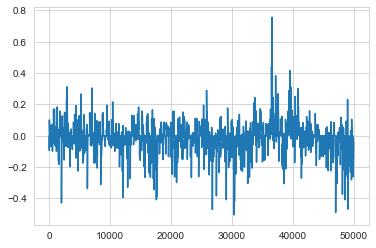

In [6]:
plt.plot(input_theory)
plt.plot()

In [21]:
start_scope()
IN = Barrel_IN(p.dt, inj_current)

IN_neuron = IN.getNeurongroup()

IN_M = StateMonitor(IN_neuron, 'v', record=True)
IN_S = SpikeMonitor(IN_neuron, 'v', record = True)

run(p.duration*ms)

NameError: name 'PC' is not defined

In [ ]:
(IN_S.num_spikes)

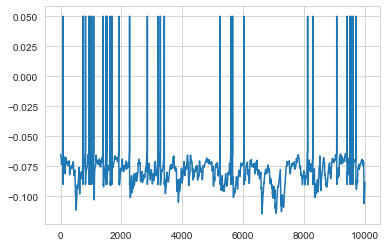

In [8]:
plot(IN_M.t / ms, IN_M.v[0], label='IN_pre')

In [9]:
start_scope()
#Initialising the neuron classes using both inj_current_IN
PC = Barrel_PC(p.dt, inj_current)
IN = Barrel_IN(p.dt, inj_current)
#Getting the neurongroups, PC_neuron returns a neurongroup with two neurons.
PC_neuron = PC.getNeurongroup()
IN_neuron = IN.getNeurongroup()
#Making a brain2 network with the neurons
net = Network(PC_neuron, IN_neuron)

PC_M = StateMonitor(PC_neuron, 'v', record=True)
PC_S = SpikeMonitor(PC_neuron, 'v', record =True)
IN_M = StateMonitor(IN_neuron, 'v', record=True)
IN_S = SpikeMonitor(IN_neuron, 'v', record =True)

net.add(PC_M, IN_M, PC_S, IN_S)
#Setting the weight and the delay for the synapses, and connect the interneuron to the second excitatory neuron
w = 4.3
delay = 0.6

syn = Synapses(IN_neuron, PC_neuron, on_pre='''v_post += w*mV''', delay= delay*ms, dt=p.dt * ms)
syn.connect(i=0, j=1)
net.add(syn)

net.run(p.duration*ms)

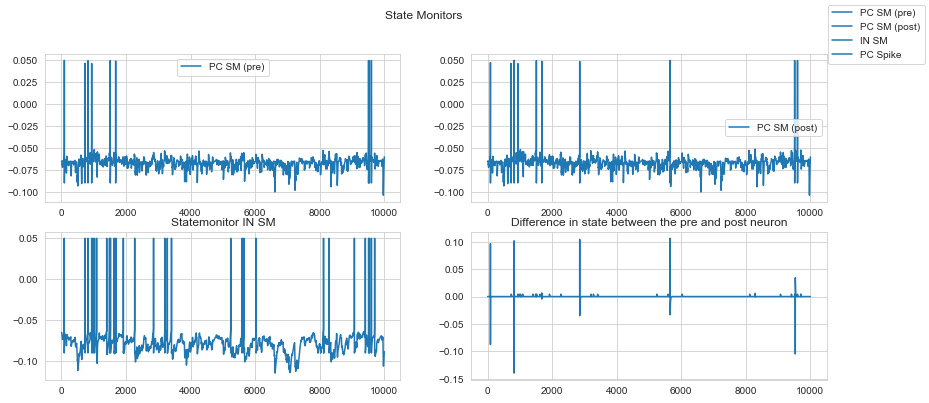

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(14,6))

axs[0, 0].plot(PC_M.t/ms, PC_M.v[0], label= 'PC SM (pre)')
axs[0,0].legend()
axs[0, 1].plot(PC_M.t/ms, PC_M.v[1], label= 'PC SM (post)')
axs[0,1].legend()

axs[1, 0].plot(IN_M.t/ms, IN_M.v[0], label= 'IN SM')
axs[1, 0].set_title('Statemonitor IN SM')

axs[1, 1].plot(PC_M.t/ms, PC_M.v[1] - PC_M.v[0], label= 'PC Spike')
axs[1, 1].set_title('Difference in state between the pre and post neuron')

fig.suptitle('State Monitors')
fig.legend()
plt.show()

## Analyzing the network

In [11]:
#the spiketrain of the modulated neuron
spiketrain_PC = make_spiketrain(PC_S.values('v')[1])
spiketrain_IN = make_spiketrain(IN_S)

TypeError: float() argument must be a string or a number, not 'TimedArray'

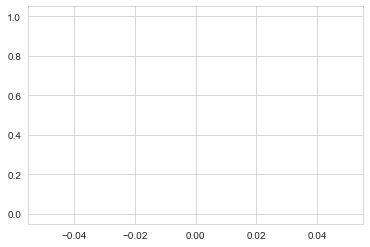

In [12]:
plt.plot(spiketrain_PC)
plt.plot(inj_current, label = 'inj_current')
plt.plot(hidden_state, label='hidden_state')
plt.show()

In [ ]:
output_PC = analyze_exp(hidden_state, input_theory, 0, spiketrain_PC, p.duration/p.sampling_rate, 'PC neuron')
output_IN = analyze_exp(hidden_state, input_theory, 0, spiketrain_IN, p.duration/p.sampling_rate, 'Input neuron')

In [ ]:
output_IN

In [ ]:
output_PC

# Analyzing the network

In [ ]:
start_scope()
#Initialising the neuron classes
PC = Barrel_PC(p.dt, inj_current)
IN = Barrel_IN(p.dt, inj_current) #the barrel neuron has no input
#Getting the neuron groups
PC_neuron = PC.getNeurongroup()
IN_neuron = IN.getNeurongroup()

net2 = Network(PC_neuron,
               IN_neuron)

PC_M = StateMonitor(PC_neuron, 'v', record=True)
PC_S = SpikeMonitor(PC_neuron, 'v', record = True)
IN_M = StateMonitor(IN_neuron, 'v', record=True)
IN_S = SpikeMonitor(PC_neuron, 'v', record = True)

net2.add(PC_M, IN_M, PC_S, IN_S)
w = np.arange(1,15)
#getting all the parameters for in the synapse
delay = 0.6

syn2 = Synapses(IN_neuron, PC_neuron, on_pre='''v_post += w*mV''', delay= delay*ms, dt=p.dt * ms)
syn2.connect(i=0, j=1)
net2.add(syn2)

net2.store()

output_PC = pd.DataFrame()
output_IN = pd.DataFrame()
weights = [3,4]
samples = p.duration/p.dt

for w in weights:
    net2.restore()
    w = w
    label = str(w)
    net2.run(p.duration*ms)
    spiketrain = make_spiketrain(PC_S)

    fig, axs = plt.subplots(2, 2, figsize=(14,6))

    axs[0, 0].plot(PC_M.t/ms, PC_M.v[0], label= 'PC SM (pre)')
    axs[0,0].legend()
    axs[0, 1].plot(PC_M.t/ms, PC_M.v[1], label= 'PC SM (post)')
    axs[0,1].legend()

    axs[1, 0].plot(IN_M.t/ms, IN_M.v[0], label= 'IN SM')
    axs[1, 0].set_title('Statemonitor IN SM')

    axs[1, 1].plot(PC_M.t/ms, PC_M.v[1] - PC_M.v[0], label= 'PC Spike')
    axs[1, 1].set_title('Difference in state between the pre and post neuron')



    fig.suptitle('State Monitors')
    fig.legend()
    plt.show()

    output_PC = pd.concat([output_PC, analyze_exp(hidden_state, input_theory,0, spiketrain,samples, 'none')], axis = 0)
    output_IN = pd.concat([output_IN, analyze_exp(hidden_state, input_theory, 0, spiketrain, p.duration/p.sampling_rate, w)], axis =0)

In [ ]:
plt.figure()
plt.plot(weights, output_PC['MI_i'])
plt.show()

In [ ]:
output_IN